In [1]:
# imports
import cv2
import numpy as np
import imutils
import time
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv_imshow

import tensorflow as tf
from tensorflow.keras.utils import img_to_array

In [2]:
# defining utility functions

def sliding_window(image, step, window_size):
  # loop through the width and height of the image to detemine the movement of the sliding windo
  # the window moves in steps which corresponds to the pixels in each image (step of 1 means it will move 1px left and right
  # and this can be pretty slow and computationally expensive, so we choose 4 px), the minimum and maximum distance it can move 
  # is calculated from the start of the corner of the image to the distance obtained from the subtraction of the image shape and window size
  for y in range(0, image.shape[0] - window_size[1], step):
    for x in range(0, image.shape[1] - window_size[0], step):
      # yeild the sliding window
      yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])


def image_pyramid(image, scale_factor, minimum_image_size):
  # yeild the first image
  yield image

  while True:
    # while True, the image pyramids are continually produced until ...
    # the different sizes of the images are obtained via a scale factor
    new_image_dimension = int(image.shape[1]/scale_factor)
    image = cv2.resize(image, (new_image_dimension, new_image_dimension), cv2.INTER_CUBIC)

    # if the images formed becomes lesser than the expected minimum, we stop the pyramid
    if image.shape[0] < minimum_image_size[0] or image.shape[1] < minimum_image_size[1]:
      break

    yield image

In [3]:
# define parameters
scale_factor = 1.5
minimum_image_size = (32, 32)
window_size = (16, 16)
resize = (64, 64)
step = 4
confidence_threshold = 0.9

In [4]:
# load saved model
model = tf.keras.models.load_model('/content/densenet.h5')

In [33]:
orig_image = cv2.imread('/content/3.jpeg')
orig_image = cv2.resize(orig_image, resize, cv2.INTER_CUBIC)
h, w = orig_image.shape[:2]

In [34]:
image_pyramids = image_pyramid(orig_image, scale_factor, minimum_image_size)

ROIs = []
LOC = []

for image in image_pyramids:

  scale = orig_image.shape[1] / image.shape[1]

  for (x, y, ROI_Image) in sliding_window(image, step, window_size):
    x = int(x * scale) # scaling the output to the size of the original images
    y = int(y * scale)
    w = int(window_size[1] * scale)
    h = int(window_size[0] * scale)

    # resize the ROI Images to the size expected by the model instantiated above
    roi = cv2.resize(ROI_Image, resize)
    roi = img_to_array(roi)
    #roi = np.expand_dims(roi, axis = 0)
    roi = roi/255.0
    ROIs.append(roi)

    # append box dimensions to LOC
    LOC.append((x, y, x + w , y + h))

In [35]:
ROIs = np.array(ROIs)

start = time.time()
prediction = model.predict(ROIs)
end = time.time()
print(f'Time taken for prediction is {round((end - start), 2)}seconds')

#class_label = ['Parastizied', 'Uninfected']

labels = {}

for i, pred in enumerate(prediction):
  if (np.max(pred) == 1):
    class_label = 'Parasitized'
  elif (np.max(pred) < 1):
    class_label = 'Uninfected'

  if ((np.max(pred) > confidence_threshold) and (class_label == 'Parasitized')):
    box = LOC[i]
    
    L = labels.get(class_label, []) #search for class labels, none will be found so we return an empty list.
    L.append((box, np.max(pred))) # extend the empty list with the box dimensions and probabilities
    labels[class_label] = L #

Time taken for prediction is 2.56seconds


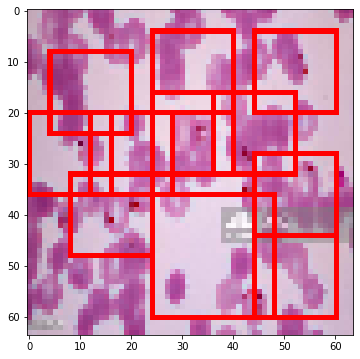

In [41]:
for label in labels.keys():

  clone = orig_image.copy()
  
  boxes = np.array([p[0] for p in labels[label]])
  probabilities = np.array([p[1] for p in labels[label]])
  boxes = non_max_suppression(boxes, probabilities)

  for (startX, startY, endX, endY) in boxes:
    cv2.rectangle(clone, (startX, startY), (endX, endY), (255, 0, 0), 1)
    
    #Y = startY - 10 if startY - 10 > 10 else startY + 10

    #cv2.putText(clone, class_label, (startX, Y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1)
  
  plt.figure(figsize= (8, 6))
  plt.imshow(clone)